In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None

In [97]:
# Config
RANDOM_STATE = 42

In [98]:
data_root = './data'

train_sales_df = pd.read_parquet(data_root + '/sales_train.parquet', engine='pyarrow')
calendar_df = pd.read_csv(data_root + '/calendar.csv')
inventory_df = pd.read_csv(data_root + '/inventory.csv')

weights_df = pd.read_csv(data_root + '/test_weights.csv')
test_df = pd.read_csv(data_root + '/sales_test.csv')
print(train_sales_df.shape, calendar_df.shape, inventory_df.shape, test_df.shape)

(4007419, 14) (23016, 7) (5432, 8) (47021, 12)


In [99]:
train_sales_df.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,0.0,0.15312,0.0,0.0
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,0.0,0.15312,0.0,0.0
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,0.0,0.15649,0.0,0.0


In [100]:
calendar_df.head()

,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse
0,2022-03-16,NaN,0,0,0,0,Frankfurt_1
1,2020-03-22,NaN,0,0,0,0,Frankfurt_1
2,2018-02-07,NaN,0,0,0,0,Frankfurt_1
3,2018-08-10,NaN,0,0,0,0,Frankfurt_1
4,2017-10-26,NaN,0,0,0,0,Prague_2


In [101]:
inventory_df.head()

,unique_id,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse
0,5255,2583,Pastry_196,Bakery,Bakery_L2_14,Bakery_L3_26,Bakery_L4_1,Prague_3
1,4948,2426,Herb_19,Fruit and vegetable,Fruit and vegetable_L2_30,Fruit and vegetable_L3_86,Fruit and vegetable_L4_1,Prague_3
2,2146,1079,Beet_2,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_65,Fruit and vegetable_L4_34,Prague_1
3,501,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_1
4,4461,2197,Chicory_1,Fruit and vegetable,Fruit and vegetable_L2_17,Fruit and vegetable_L3_33,Fruit and vegetable_L4_1,Frankfurt_1


In [102]:
test_df.head()

,unique_id,date,warehouse,total_orders,sell_price_main,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount
0,1226,2024-06-03,Brno_1,8679.0,13.13,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,1226,2024-06-11,Brno_1,8795.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0
2,1226,2024-06-13,Brno_1,10009.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0
3,1226,2024-06-15,Brno_1,8482.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0
4,1226,2024-06-09,Brno_1,8195.0,13.13,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
test_df['unique_id'].nunique()

3625

### 1. EDA


* Check nan values

In [104]:
train_sales_df.isna().mean()

unique_id          0.000000
date               0.000000
warehouse          0.000000
total_orders       0.000013
sales              0.000013
sell_price_main    0.000000
availability       0.000000
type_0_discount    0.000000
type_1_discount    0.000000
type_2_discount    0.000000
type_3_discount    0.000000
type_4_discount    0.000000
type_5_discount    0.000000
type_6_discount    0.000000
dtype: float64

* The missing ratio is low so just remove it

* Check date distribute

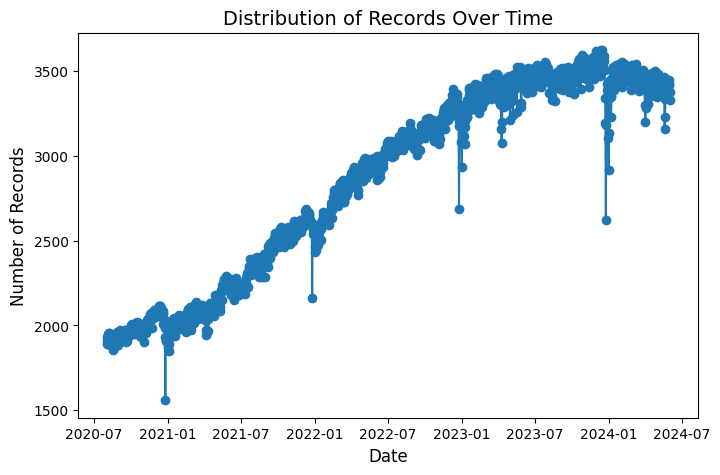

In [105]:
train_sales_df['date'] = pd.to_datetime(train_sales_df['date'])

# Count occurrences of each date
date_counts = train_sales_df['date'].value_counts().sort_index()

# Plotting the distribution
plt.figure(figsize=(8, 5))
plt.plot(date_counts.index, date_counts.values, marker='o', linestyle='-')
plt.title('Distribution of Records Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.show()

* Warehouse distribute

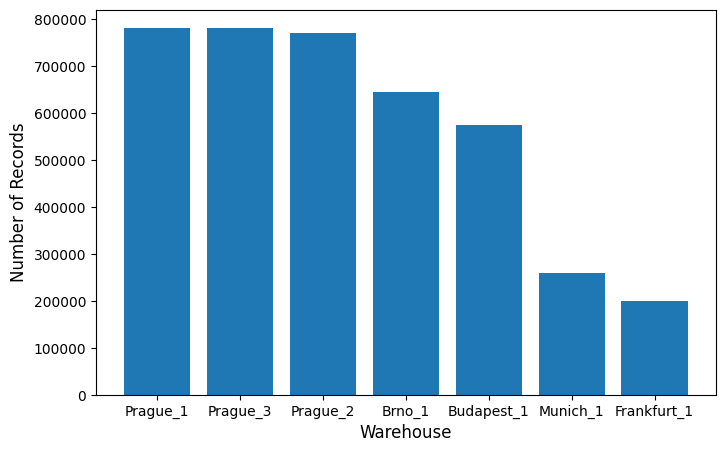

In [106]:
# Count occurrences of each date
wh_count = train_sales_df['warehouse'].value_counts()

# Plotting the distribution
plt.figure(figsize=(8, 5))
plt.bar(wh_count.index, wh_count.values)
plt.xlabel('Warehouse', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.show()

* Availability distribute

<Axes: xlabel='availability', ylabel='Count'>

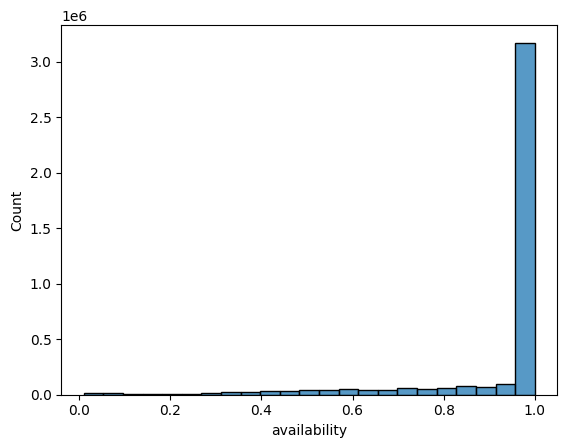

In [107]:
sns.histplot(train_sales_df['availability'])

* EDA calendar

In [108]:
calendar_df['date'] = pd.to_datetime(calendar_df['date'])
calendar_df = calendar_df.sort_values(by='date')
calendar_df.head()

,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse
7260,2016-01-01,New Years Day,1,1,0,0,Prague_2
9914,2016-01-01,New Years Day,1,1,0,0,Budapest_1
22413,2016-01-01,New Years Day,1,1,0,0,Munich_1
22407,2016-01-01,New Years Day,1,1,0,0,Prague_1
9911,2016-01-01,New Years Day,1,1,0,0,Frankfurt_1


In [109]:
# Nums holiday_name
holiday_counts = calendar_df[(calendar_df['date'] > '2016') & (calendar_df['date'] < '2017')]['holiday_name'].value_counts()
holiday_counts

holiday_name
2nd Christmas Day                                              7
1st Christmas Day                                              7
International womens day                                       7
Christmas Eve                                                  7
Labour Day                                                     7
Jan Hus                                                        4
Den boje za svobodu a demokracii                               4
Den vzniku samostatneho ceskoslovenskeho statu                 4
Den ceske statnosti                                            4
Cyrila a Metodej                                               4
Den osvobozeni                                                 4
Whit monday                                                    3
Whit sunday                                                    3
German Unity Day                                               2
Memorial Day for the Victims of the Holocaust                  2
Ascension da

In [110]:
calendar_df['school_holidays'].value_counts()

school_holidays
0    22863
1      153
Name: count, dtype: int64

* EDA inventory

In [111]:
print(inventory_df.shape)
inventory_df.head()

(5432, 8)


,unique_id,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse
0,5255,2583,Pastry_196,Bakery,Bakery_L2_14,Bakery_L3_26,Bakery_L4_1,Prague_3
1,4948,2426,Herb_19,Fruit and vegetable,Fruit and vegetable_L2_30,Fruit and vegetable_L3_86,Fruit and vegetable_L4_1,Prague_3
2,2146,1079,Beet_2,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_65,Fruit and vegetable_L4_34,Prague_1
3,501,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_1
4,4461,2197,Chicory_1,Fruit and vegetable,Fruit and vegetable_L2_17,Fruit and vegetable_L3_33,Fruit and vegetable_L4_1,Frankfurt_1


In [112]:
# Nums unique_id and product_unique_id
inventory_df['unique_id'].nunique(), inventory_df['product_unique_id'].nunique()

(5432, 2670)

In [113]:
dup_unique_id = inventory_df[inventory_df.duplicated(subset='product_unique_id', keep=False)]
dup_unique_id.head()

,unique_id,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse
0,5255,2583,Pastry_196,Bakery,Bakery_L2_14,Bakery_L3_26,Bakery_L4_1,Prague_3
1,4948,2426,Herb_19,Fruit and vegetable,Fruit and vegetable_L2_30,Fruit and vegetable_L3_86,Fruit and vegetable_L4_1,Prague_3
2,2146,1079,Beet_2,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_65,Fruit and vegetable_L4_34,Prague_1
3,501,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_1
4,4461,2197,Chicory_1,Fruit and vegetable,Fruit and vegetable_L2_17,Fruit and vegetable_L3_33,Fruit and vegetable_L4_1,Frankfurt_1


In [114]:
dup_unique_id[dup_unique_id['product_unique_id'] == 260]

,unique_id,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse
3,501,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_1
2452,500,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_2
4885,499,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_3
5313,502,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Brno_1


* Seem unique_id indicate for specific warehouse and same product_id

In [115]:
# Check product id
cols = ['product_unique_id', 'name', 'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en']
inventory_df.drop_duplicates(subset=cols, keep='first').shape[0] == inventory_df['product_unique_id'].nunique()

True

### 2. Data Processing

* 1. Dealing with missing values

In [116]:
# Because missing ratio is very low so just drop missing values
print('Shape before ', train_sales_df.shape)
train_sales_df = train_sales_df.dropna()
print('Shape after ' ,train_sales_df.shape)

Shape before  (4007419, 14)
Shape after  (4007367, 14)


In [117]:
train_sales_df.isna().sum().sum()

0

In [118]:
def data_processing(sales_df, calendar_df, inventory_df):
    sales_df['date'] = pd.to_datetime(sales_df['date'])
    # Mapping holidays infor
    df = pd.merge(sales_df, calendar_df, on=['date', 'warehouse'], how='left')

    # Mapping product_infor
    df = pd.merge(df, inventory_df, on=['unique_id', 'warehouse'], how='left')

    # Convert NaN values in holiday_name to empty string
    df['holiday_name'] = df['holiday_name'].fillna('')
    
    # Create year, month, date cols
    df['year'] = df['date'].dt.year
    df['quater'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['month_name'] = df['date'].dt.month_name()
    df['day_of_week'] = df['date'].dt.day_name()
    df['week'] = df['date'].dt.isocalendar().week
    df['year_sin']  = np.sin(2*np.pi*df['year'])
    df['year_cos'] = np.cos(2*np.pi*df['year'])

    df['month_sin']  = np.sin(2*np.pi*df['month']/12)
    df['month_cos'] = np.cos(2*np.pi*df['month']/12)

    df['day_sin']  = np.sin(2*np.pi*df['day']/31)
    df['day_cos'] = np.cos(2*np.pi*df['day']/31)
    df['group'] = (df['year'] - 2020)*48 + df['month']*4 + df['day']//7

    # Drop some cols not use for prediction
    df = df.drop(columns=['date'], axis=1)
    
    # Convert category datatype
    cate_cols = ['warehouse', 'name', 'holiday_name', 'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en', 'month_name', 'day_of_week']
    df[cate_cols] = df[cate_cols].astype('category')

    return df

train_df = data_processing(train_sales_df, calendar_df, inventory_df)
train_df.head()

,unique_id,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,year,quater,month,day,month_name,day_of_week,week,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,group
0,4845,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,0.0,0.15312,0.0,0.0,,0,0,0,0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,2024,1,3,10,March,Sunday,10,1.585375e-14,1.0,1.000000e+00,6.123234e-17,0.897805,-0.440394,205
1,4845,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0,,0,0,0,0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,2021,2,5,25,May,Tuesday,21,-1.468363e-13,1.0,5.000000e-01,-8.660254e-01,-0.937752,0.347305,71
2,4845,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0,,0,0,0,0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,2021,4,12,20,December,Monday,51,-1.468363e-13,1.0,-2.449294e-16,1.000000e+00,-0.790776,-0.612106,98
3,4845,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,0.0,0.15312,0.0,0.0,,0,0,0,0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,2023,2,4,29,April,Saturday,17,-6.447061e-13,1.0,8.660254e-01,-5.000000e-01,-0.394356,0.918958,164
4,4845,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,0.0,0.15649,0.0,0.0,,0,0,0,0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,2022,2,4,1,April,Friday,13,-1.305266e-12,1.0,8.660254e-01,-5.000000e-01,0.201299,0.979530,112


In [119]:
X_test = data_processing(test_df, calendar_df, inventory_df)
X_test.head()

,unique_id,warehouse,total_orders,sell_price_main,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,year,quater,month,day,month_name,day_of_week,week,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,group
0,1226,Brno_1,8679.0,13.13,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,,0,0,0,0,627,Croissant_9,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,2024,2,6,3,June,Monday,23,1.585375e-14,1.0,1.224647e-16,-1.0,0.571268,0.820763,216
1,1226,Brno_1,8795.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0,,0,0,0,0,627,Croissant_9,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,2024,2,6,11,June,Tuesday,24,1.585375e-14,1.0,1.224647e-16,-1.0,0.790776,-0.612106,217
2,1226,Brno_1,10009.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0,,0,0,0,0,627,Croissant_9,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,2024,2,6,13,June,Thursday,24,1.585375e-14,1.0,1.224647e-16,-1.0,0.485302,-0.874347,217
3,1226,Brno_1,8482.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0,,0,0,0,0,627,Croissant_9,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,2024,2,6,15,June,Saturday,24,1.585375e-14,1.0,1.224647e-16,-1.0,0.101168,-0.994869,218
4,1226,Brno_1,8195.0,13.13,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,,0,0,0,0,627,Croissant_9,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,2024,2,6,9,June,Sunday,23,1.585375e-14,1.0,1.224647e-16,-1.0,0.968077,-0.250653,217


### 3. Training

In [120]:
cate_cols = ['warehouse', 'name', 'holiday_name', 'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en', 'month_name', 'day_of_week']

In [121]:
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=RANDOM_STATE)
X_train, y_train = train_data.drop(columns=['sales']), train_data['sales']
X_val, y_val = val_data.drop(columns=['sales']), val_data['sales']
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((3205893, 37), (3205893,), (801474, 37), (801474,))

* Handle weights

In [124]:
train_unique_ids = X_train['unique_id'].values
val_unique_ids = X_val['unique_id'].values
train_unique_ids.shape, val_unique_ids.shape

((3205893,), (801474,))

In [130]:
def get_unique_id_weights(ids, weights_df):
    weight_map = dict(zip(weights_df['unique_id'], weights_df['weight']))

    # Get coressponding weights
    weights = [weight_map[uid] for uid in ids]
    weights = np.array(weights)

    return weights

train_weights = get_unique_id_weights(train_unique_ids, weights_df)
val_weights = get_unique_id_weights(val_unique_ids, weights_df)

In [135]:
def custom_eval_with_weights(y_pred, y_actual, weights):
    # Tính toán WMAE
    absolute_errors = abs(y_pred - y_actual)
    weighted_absolute_errors = absolute_errors * weights
    wmae = weighted_absolute_errors.sum() / sum(weights)
    
    return wmae  # False vì WMAE là "lower is better"

# # Hàm đánh giá tùy chỉnh (custom evaluation)
# def custom_eval(preds, data):
#     labels = data.get_label()
#     rmse = mean_squared_error(labels, preds, squared=False)
#     return 'custom_rmse', rmse, False  # False vì RMSE là "lower is better"

# # Create dataset for lightGBM
# train_set = lgb.Dataset(X_train, label=y_train, categorical_feature=cate_cols)
# val_set = lgb.Dataset(X_val, label=y_val, categorical_feature=cate_cols, reference=train_set)

# 2. Định nghĩa tham số và custom evaluation function
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,  # Giảm số lượng lá
    'min_data_in_leaf': 20,  # Số lượng mẫu tối thiểu trong một lá
    'seed': 42
}

# # 3. Huấn luyện mô hình với callback early_stopping
# model = lgb.train(
#     params,
#     train_set,
#     num_boost_round=2000,
#     valid_sets=[train_set, val_set],
#     valid_names=['train', 'val'],
#     feval=custom_eval,  # Dùng hàm đánh giá tùy chỉnh
#     callbacks=[
#         lgb.early_stopping(stopping_rounds=50),  # Callback dừng sớm
#         lgb.log_evaluation(period=100)          # Log mỗi 100 vòng
#     ]
# )

In [136]:
from sklearn.metrics import mean_squared_error

# Chuẩn bị dữ liệu train và validation
train_set = lgb.Dataset(X_train, label=y_train, categorical_feature=cate_cols)
val_set = lgb.Dataset(X_val, label=y_val, reference=train_set)

# Khởi tạo mô hình LightGBM (tương tự random initialization trong DL)
model = lgb.Booster(params, train_set)

# Số vòng lặp huấn luyện (epochs)
num_epochs = 200
early_stopping_rounds = 10
best_val_loss = float('inf')
stopping_counter = 0

# Vòng lặp huấn luyện
for epoch in range(num_epochs):
    # Huấn luyện một vòng
    model.update(train_set)  # Cập nhật mô hình với dữ liệu train

    # Dự đoán trên tập validation
    y_val_preds = model.predict(X_val, num_iteration=model.current_iteration())
    y_train_preds = model.predict(X_train, num_iteration=model.current_iteration())

    # Tính toán loss trên tập validation
    # val_loss = mean_squared_error(y_val, y_val_preds, squared=False)  # RMSE
    val_loss = custom_eval_with_weights(y_val, y_val_preds, val_weights)
    train_loss = custom_eval_with_weights(y_train, y_train_preds, train_weights)

    # Log thông tin
    print(f"Epoch {epoch + 1}, Validation loss: {val_loss:.4f}, Train loss: {train_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        stopping_counter = 0  # Reset bộ đếm khi có cải thiện
    else:
        stopping_counter += 1

    if stopping_counter >= early_stopping_rounds:
        print(f"Early stopping at epoch {epoch + 1}")
        break


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 3205893, number of used features: 36
[LightGBM] [Info] Start training from score 108.386328
Epoch 1, Validation loss: 82.1055, Train loss: 82.3888
Epoch 2, Validation loss: 76.9936, Train loss: 77.2652
Epoch 3, Validation loss: 72.7074, Train loss: 72.9658
Epoch 4, Validation loss: 68.6435, Train loss: 68.8969
Epoch 5, Validation loss: 65.3242, Train loss: 65.5786
Epoch 6, Validation loss: 62.0873, Train loss: 62.3355
Epoch 7, Validation loss: 59.

KeyboardInterrupt: 

In [ ]:

# Dự đoán trên tập test sau khi huấn luyện hoàn tất
y_test_preds = model.predict(X_test, num_iteration=model.best_iteration)
test_rmse = mean_squared_error(y_test, y_test_preds, squared=False)
print(f"Test RMSE: {test_rmse:.4f}")
